In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import (models, transforms)
import os
import utils
from pathlib import Path
import trainer
from torchinfo import summary
import time
import matplotlib.pyplot as plt
import numpy as np
import simplify
import torch.nn.utils.prune as prune

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/p3rzival/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
vit_default = utils.load_default_model()
loss_fn = nn.CrossEntropyLoss()
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit_transforms = pretrained_vit_weights.transforms()
summary(vit_default.encoder.layers.encoder_layer_0.mlp, input_size=(32, 197, 768))

Layer (type:depth-idx)                   Output Shape              Param #
MLPBlock                                 [32, 197, 768]            --
├─Linear: 1-1                            [32, 197, 3072]           2,362,368
├─GELU: 1-2                              [32, 197, 3072]           --
├─Dropout: 1-3                           [32, 197, 3072]           --
├─Linear: 1-4                            [32, 197, 768]            2,360,064
├─Dropout: 1-5                           [32, 197, 768]            --
Total params: 4,722,432
Trainable params: 4,722,432
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 151.12
Input size (MB): 19.37
Forward/backward pass size (MB): 193.66
Params size (MB): 18.89
Estimated Total Size (MB): 231.91

In [3]:
prunning = 0.7999
pruned_model = utils.prune_vit(vit_default, prunning)
pruned_model.load_state_dict(torch.load(f"model/ViT-Prunning{prunning:.2f}-Best.pht", weights_only=True))

<All keys matched successfully>

In [4]:
_, _, val_dl, _ = utils.create_loaders("data", transform=pretrained_vit_transforms, batch_size=32)
loss_fn = nn.CrossEntropyLoss()

Files already downloaded and verified


In [5]:
for parameter in pruned_model.parameters():
    parameter.requires_grad = False

In [ ]:
#trainer.evaluate(pruned_model, val_dl, loss_fn, device)

Doing warm-up runs...
Ended warm-up, beginning true runs...


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


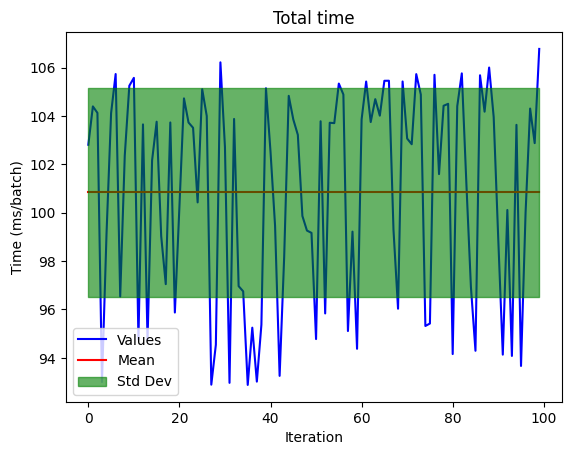

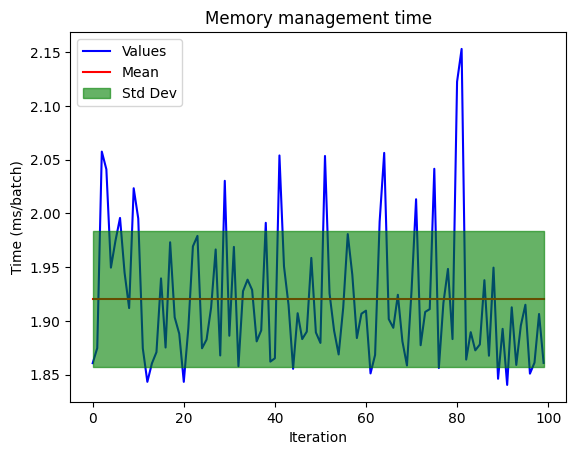

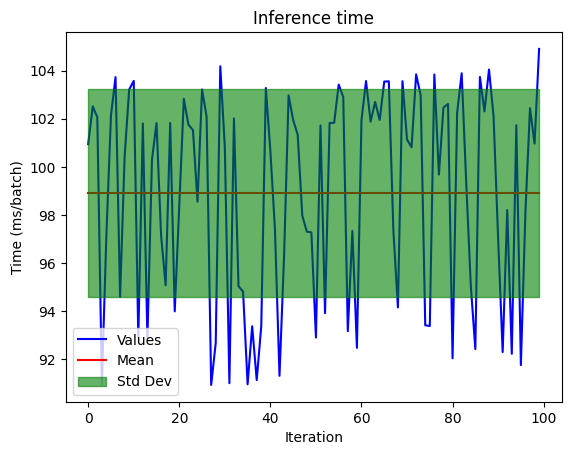

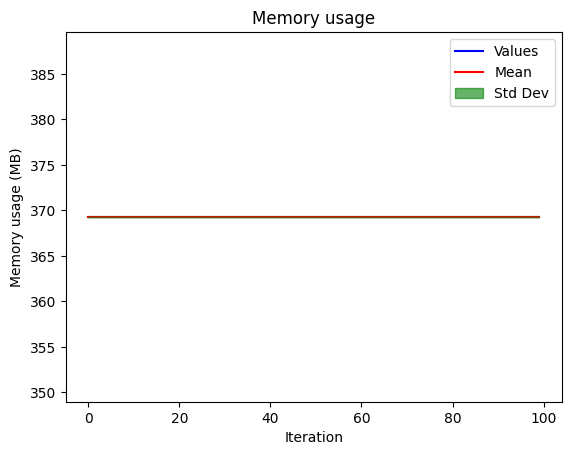

Mean total time over 100 executions: 100.84156513214111 ms/batch 
Mean memory time over 100 executions: 1.920163631439209 ms/batch 
Mean inference time over 100 executions: 98.9214015007019 ms/batch 
Mean memory over 100 executions: 369.27783203125 MB


In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
metrics = trainer.getMetrics(pruned_model, val_dl, device, num_times=100, save_plots=True, model_title=f'ViT-Prunning-80')